HACKDAY CDS - TIME 1

# PROJECT SOLUTION PLANNING

A mobilidade tem um papel fundamental no dia a dia da população de qualquer país, e no Brasil, o cenário não é diferente. Novas formas de abordar o tema têm se popularizado cada vez mais nos últimos anos, como o aumento de práticas de aluguel de veículos, e a busca dos consumidores por locações de veículos por assinatura.

Segundo a Associação Brasileira das Locadoras de Automóveis (ABLA), o faturamento bruto do segmento, que tem no Brasil 13.903 locadoras ativas, deu um salto de 33,5% no ano de 2021, e chegou ao recorde de R$ 23,5 bilhões.¹

Ainda segundo a mesma matéria da ABLA, em 2021, as locadoras compraram 441.858 carros zero quilômetro, equivalentes a 25,5% de todos os automóveis emplacados no ano. Houve portanto um crescimento de 22,5% em relação às compras feitas em 2020 (360.567 unidades).

Junto ao aumento da frota de veículos, aumenta também a necessidade de um incremento na venda dos seminovos por parte das locadoras. Isto garante a viabilidade do negócio, visto que:

Aumenta o poder de barganha na aquisição de novos veículos junto as montadoras.
Evita custos de manutenção cada vez mais altos, em decorrência do desgaste dos veículos ao longo do tempo.
Mantém a frota atualizada com relação as novas tecnologias presentes nos novos veículos.
Reforça uma postura sustentável da empresa, com veículos projetados cada vez mais com foco na sustentabilidade.
Este desafio aborda o case da locadora Mobility Cars, tradicional player do segmento de locação de veículos, presente em todo o território brasileiro.

A empresa está com dificuldades de atingir as metas de vendas de seminovos, e por isso vem amargurando quedas nos seus resultados. Ela precisa com urgência voltar a vender mais, para poder seguir renovando a sua frota, mantendo assim sua competitividade diante da concorrência.

A empresa utiliza hoje como referência de valores de veículos a tabela FIPE², amplamente difundida no mercado nacional. Porém, é comum esta referência não ser assertiva para definir o valor real praticado pelo mercado, a depender da marca e modelo do veículo.

O objetivo desta competição é desenvolver um modelo de regressão, que com base no histórico de valores de venda de veículos praticados em todo o Brasil, seja capaz de construir uma tabela de referência de preços condizente com a realidade do mercado brasileiro.

A diretoria comercial da Mobility Cars, está convicta de que a nova tabela de referência será a peça chave para reverter o quadro negativo atual. Com ela, a empresa voltará a atingir as metas de vendas de seminovos estipuladas, retomando sua posição de destaque no mercado.

Materiais & Referências:

1 - ABLA- Estatísticas do aluguel de veículos em 2021
2 - Tabela FIPE

## Input

1. Business problem
    - A empresa está com dificuldades de atingir as metas de vendas de seminovos, e por isso vem amargurando quedas nos seus resultados. Ela precisa com urgência voltar a vender mais, para poder seguir renovando a sua frota, mantendo assim sua competitividade diante da concorrência.
    
2. Datasets:

    - **treino.csv**
    - **teste.csv**


## Output


- Desenvolver um modelo de regressão, que com base no histórico de valores de venda de veículos praticados em todo o Brasil, seja capaz de construir uma tabela de referência de preços condizente com a realidade do mercado brasileiro.

1. Deliverables:

- Model's performance and results report with the following topics:
    - Preço por ID

## Tasks

**Project Development Method**

The project was developed based on the CRISP-DS (Cross-Industry Standard Process - Data Science, a.k.a. CRISP-DM) project management method, with the following steps:

- Project Planning
- Business Understanding;
- Data Collection;
- Data Cleaning;
- Exploratory Data Analysis (EDA);
- Data Preparation;
- Machine Learning Modelling and fine-tuning;
- Model and Business performance evaluation / Results;
- Model deployment.


<img src="https://www.researchgate.net/profile/Youssef-Tounsi-2/publication/341627969/figure/fig1/AS:903550875996160@1592434724532/CRISP-DM-data-mining-framework.png" alt="some text" width=500 height=400 align="left">


# Imports

In [152]:
import math
import pandas                as pd
import numpy                 as np
import seaborn               as sns
import matplotlib.pyplot     as plt
import datetime
import inflection
import warnings
import random
import pickle
import json

import xgboost               as xgb
import lightgbm              as lgbm
    
from pandas.api.types        import is_string_dtype, is_numeric_dtype
from matplotlib              import gridspec
from scipy                   import stats as ss
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from boruta                  import BorutaPy

from IPython.core.display    import HTML
from IPython.display         import Image

# Versão da Linguagem Python
from platform                import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())
warnings.filterwarnings( 'ignore' )

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.2


## Helper Functions

In [30]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values # Confusion Matrix
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def mean_absolute_percentage_error( y, yhat ):
    y, yhat = np.array(y), np.array(yhat)
    return np.mean( np.abs( ( y-yhat ) / y ))

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

# Define the function to evaluate the models
def weighted_mean_absolute_error(df, y, yhat):
    weights = df.is_holiday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(y-yhat))/(np.sum(weights)), 2)

def ml_error( df,model_name, y, yhat):
    mae = mean_absolute_error( y,yhat )
    mape = mean_absolute_percentage_error( y,yhat )
    rmse = np.sqrt(mean_squared_error( y,yhat ))
    WMAE = weighted_mean_absolute_error(df, y, yhat)
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'RMSE': rmse,
                          'WMAE': WMAE}, index=[0])

# time-series cross validation implementation
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    WMAE_list = []
     
    for k in reversed( range( 1, kfold+1 ) ): #k-fold implementation
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        start_date_validation = x_training['date'].max() - datetime.timedelta( weeks=k*22) #primeira semanada da venda realizada
        end_date_validation = x_training['date'].max() - datetime.timedelta( weeks=(k-1)*22) #ultima semana

        # filtering dataset
        training = x_training[x_training['date'] < start_date_validation]
        validation = x_training[(x_training['date'] >= start_date_validation) & (x_training['date'] <= end_date_validation)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'weekly_sales'], axis=1 ) 
        ytraining = training['weekly_sales']

        # validation
        xvalidation = validation.drop( ['date', 'weekly_sales'], axis=1 )
        yvalidation = validation['weekly_sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error( xvalidation, model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        rmse_list.append( m_result['RMSE'] )
        WMAE_list.append( m_result['WMAE'])

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV':  np.round( np.mean( mae_list ), 2 ).astype( str )  + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ),
                          'WMAE CV': np.round( np.mean( WMAE_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( WMAE_list ), 2 ).astype( str )}, index=[0] )


In [31]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# LOADING DATA

In [14]:
#project home path for importing files
home_path = '/home/marxcerqueira/repos/hackday-cds-time1/'

#loading datasets available for this project
df_treino              = pd.read_csv(home_path + 'data/treino.csv', low_memory = False)
df_teste               = pd.read_csv(home_path + 'data/teste.csv', low_memory = False)
df_sample_submission   = pd.read_csv(home_path + 'data/sample_submission.csv', low_memory = False)


In [15]:
#first look at the dataframes
df_treino.head()

,ID,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,tipo_anuncio,entrega_delivery,troca,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado,preco
0,105869496634249611881157692933406072990,8.0,VOLKSWAGEN,AMAROK,2.0 TRENDLINE 4X4 CD 16V TURBO INTERCOOLER DIE...,2017,2017.0,55672.0,Automática,4,Picape,N,Preto,PF,São Paulo,São Paulo (SP),Pessoa Física,False,False,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,NaN,Todas as revisões feitas pela agenda do carro,NaN,123231.992782
1,14165644411757892901957277406025007093,8.0,JAGUAR,F-PACE,2.0 16V TURBO DIESEL PRESTIGE AWD 4P AUTOMÁTICO,2017,2017.0,47858.0,Automática,4,Utilitário esportivo,N,Branco,PF,Rio de Janeiro,Rio Grande do Sul (RS),Pessoa Física,False,False,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,IPVA pago,NaN,NaN,Todas as revisões feitas pela agenda do carro,NaN,272076.023576
2,78515656948521351316652580664682810356,14.0,CHEVROLET,CRUZE,1.8 LT 16V FLEX 4P AUTOMÁTICO,2012,2013.0,122323.0,Automática,4,Sedã,N,Prata,PJ,Rio de Janeiro,São Paulo (SP),Loja,True,True,False,Aceita troca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53411.539492
3,36797041166808090517929207429817328298,8.0,PORSCHE,718,2.0 16V H4 GASOLINA BOXSTER PDK,2020,2021.0,14207.0,Automática,2,Picape,N,Branco,PF,São Paulo,São Paulo (SP),Pessoa Física,False,False,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,NaN,NaN,NaN,NaN,NaN,299697.071937
4,338618517701891995317200439137014723900,8.0,VOLVO,XC90,2.0 INSCRIPTION TURBO GASOLINA 4P 4X4 AUTOMÁTICO,2015,2016.0,43760.0,Automática,4,Utilitário esportivo,N,Preto,PF,Ribeirão Preto,São Paulo (SP),Pessoa Física,False,False,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,NaN,NaN,NaN,Todas as revisões feitas pela agenda do carro,NaN,255164.344178


In [16]:
#first look at the dataframes
df_teste.head()

,ID,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,tipo_anuncio,entrega_delivery,troca,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado
0,24813264385557040124808779273028388499,14.0,CHEVROLET,SPIN,1.8 LTZ 8V FLEX 4P AUTOMÁTICO,2017,2017.0,62969.0,Automática,4,Sedã,N,Branco,PJ,Recife,Santa Catarina (SC),Loja,False,False,False,Aceita troca,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,295636316453795508942188530111300065666,8.0,FIAT,TORO,1.8 16V EVO FLEX FREEDOM AT6,2021,2021.0,26324.0,Automática,4,Picape,N,Branco,PF,São Paulo,São Paulo (SP),Pessoa Física,False,False,False,Aceita troca,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,NaN
2,101258309166227950735244624080888109884,8.0,VOLKSWAGEN,POLO,1.0 200 TSI HIGHLINE AUTOMÁTICO,2019,2020.0,37002.0,Automática,4,Hatchback,N,Branco,PF,São Paulo,São Paulo (SP),Pessoa Física,False,False,False,NaN,Único dono,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,Garantia de fábrica,Todas as revisões feitas pela agenda do carro,NaN
3,28348734455782469411126661985772047409,15.0,CHEVROLET,TRACKER,1.8 MPFI LTZ 4X2 16V FLEX 4P AUTOMÁTICO,2012,2015.0,86762.0,Automática,4,Sedã,N,Branco,PJ,Rio de Janeiro,Rio de Janeiro (RJ),Loja,False,False,False,Aceita troca,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,193163160502972147671913739170248305797,8.0,BMW,120i,2.0 16V SPORT ACTIVEFLEX 4P AUTOMÁTICO,2015,2017.0,93040.0,Automática,4,Sedã,N,Branco,PF,Campo Grande,Rio Grande do Sul (RS),Pessoa Física,False,False,False,NaN,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,NaN


In [20]:
df_sample_submission.head()

,ID,preco
0,24813264385557040124808779273028388499,134829.562524
1,295636316453795508942188530111300065666,185573.018383
2,101258309166227950735244624080888109884,115475.455269
3,28348734455782469411126661985772047409,214619.215264
4,193163160502972147671913739170248305797,143094.784514


# DATA DISCRIPTION

In [189]:
#Copy dataset
df1 = df_treino.copy()

## Rename Columns

In [33]:
# checking columns
df1.columns

Index(['ID', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado', 'preco'],
      dtype='object')

In [19]:
columns = ['ID', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao','ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado','cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor','tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao','attr_veiculo_aceita_troca', 'attr_veiculo_único_dono','attr_veiculo_todas_as_revisões_feitas_pela_concessionária','attr_veiculo_ipva_pago', 'attr_veiculo_licenciado','attr_veiculo_garantia_de_fábrica','attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro','attr_veiculo_alienado', 'preco']

## Data Dimension

In [91]:
# checking data dimesions to see if we have enough computational power
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 39446
Number of Cols: 29


## Data Types

In [79]:
# checking features dtypes
df1.dtypes

ID                                                             object
num_fotos                                                     float64
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                    float64
odometro                                                      float64
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

## Check NA Values

In [73]:
# checking NA values sum and its percentagem from total number of rows
missing_count = df1.isnull().sum() # the count of missing values
value_count = df1.isnull().count() # the count of all values

missing_percentage = round(missing_count/value_count *100, 2) # the percentage of missing values
missing_df = pd.DataFrame({'missing values count': missing_count, 'percentage': missing_percentage})
missing_df

,missing values count,percentage
ID,0,0.00
num_fotos,237,0.60
marca,0,0.00
modelo,0,0.00
versao,0,0.00
ano_de_fabricacao,0,0.00
ano_modelo,0,0.00
odometro,0,0.00
cambio,0,0.00
num_portas,0,0.00


In [125]:
df1.num_fotos.value_counts()

8.0     25846
15.0     3725
16.0     2980
14.0     2412
17.0     1300
9.0       999
13.0      960
20.0      369
18.0      315
12.0      209
19.0       57
11.0       26
21.0        8
10.0        3
Name: num_fotos, dtype: int64

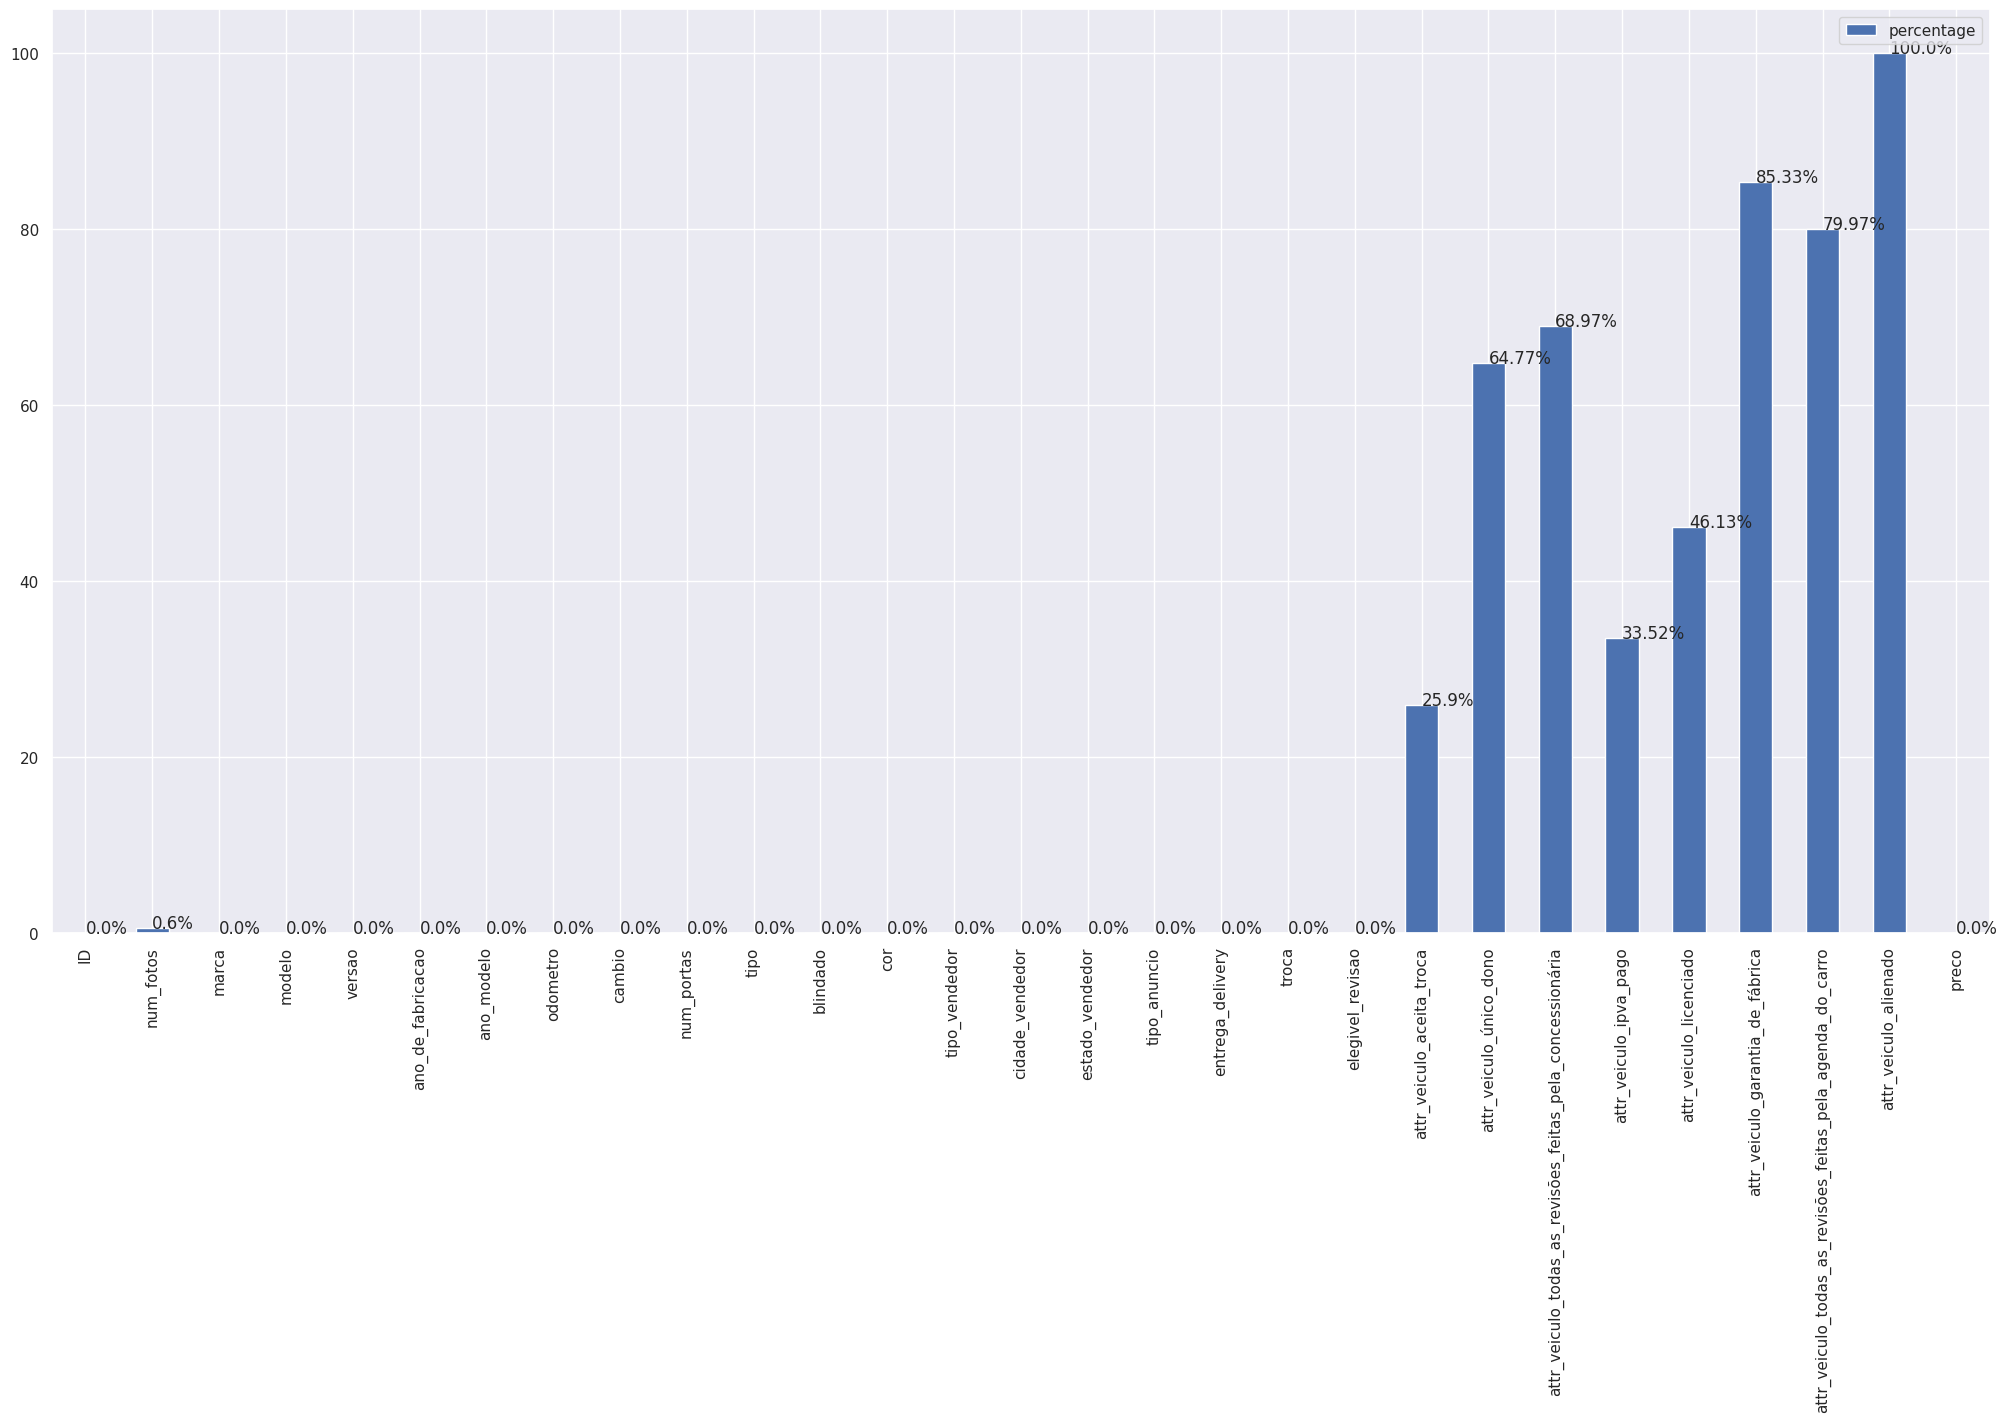

In [74]:
# missing na chart
barchart = missing_df.plot.bar(y='percentage')
for index, percentage in enumerate( missing_percentage ):
    barchart.text( index, percentage, str(percentage)+'%')

## Fillout NA

In [75]:
df1.head()

,ID,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,tipo_anuncio,entrega_delivery,troca,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado,preco
0,105869496634249611881157692933406072990,8.0,VOLKSWAGEN,AMAROK,2.0 TRENDLINE 4X4 CD 16V TURBO INTERCOOLER DIE...,2017,2017.0,55672.0,Automática,4,Picape,N,Preto,PF,São Paulo,São Paulo (SP),Pessoa Física,False,False,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,NaN,Todas as revisões feitas pela agenda do carro,NaN,123231.992782
1,14165644411757892901957277406025007093,8.0,JAGUAR,F-PACE,2.0 16V TURBO DIESEL PRESTIGE AWD 4P AUTOMÁTICO,2017,2017.0,47858.0,Automática,4,Utilitário esportivo,N,Branco,PF,Rio de Janeiro,Rio Grande do Sul (RS),Pessoa Física,False,False,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,IPVA pago,NaN,NaN,Todas as revisões feitas pela agenda do carro,NaN,272076.023576
2,78515656948521351316652580664682810356,14.0,CHEVROLET,CRUZE,1.8 LT 16V FLEX 4P AUTOMÁTICO,2012,2013.0,122323.0,Automática,4,Sedã,N,Prata,PJ,Rio de Janeiro,São Paulo (SP),Loja,True,True,False,Aceita troca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53411.539492
3,36797041166808090517929207429817328298,8.0,PORSCHE,718,2.0 16V H4 GASOLINA BOXSTER PDK,2020,2021.0,14207.0,Automática,2,Picape,N,Branco,PF,São Paulo,São Paulo (SP),Pessoa Física,False,False,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,NaN,NaN,NaN,NaN,NaN,299697.071937
4,338618517701891995317200439137014723900,8.0,VOLVO,XC90,2.0 INSCRIPTION TURBO GASOLINA 4P 4X4 AUTOMÁTICO,2015,2016.0,43760.0,Automática,4,Utilitário esportivo,N,Preto,PF,Ribeirão Preto,São Paulo (SP),Pessoa Física,False,False,False,Aceita troca,NaN,Todas as revisões feitas pela concessionária,NaN,NaN,NaN,Todas as revisões feitas pela agenda do carro,NaN,255164.344178


In [57]:
df1.columns

Index(['ID', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado', 'preco'],
      dtype='object')

In [190]:
# assumptions:
# valores NAs são 0
df1['num_fotos'] = df1['num_fotos'].apply(lambda x: 1 if x==True else 0)

#entrega_delivery
df1['entrega_delivery'] = df1['entrega_delivery'].apply(lambda x: 1 if x==True else 0)

# troca
df1['troca'] = df1['troca'].apply(lambda x: 1 if x==True else 0)

# elegivel_revisao
df1['elegivel_revisao'] = df1['elegivel_revisao'].apply(lambda x: 1 if x==True else 0)

# converting to binary data
# attr_veiculo_aceita_troca
df1['attr_veiculo_aceita_troca'] = pd.get_dummies(df1['attr_veiculo_aceita_troca'])

# 'attr_veiculo_único_dono'
df1['attr_veiculo_único_dono'] = pd.get_dummies(df1['attr_veiculo_único_dono'])

# 'attr_veiculo_todas_as_revisões_feitas_pela_concessionária'
df1['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'] = pd.get_dummies(df1['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'])

# 'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
df1['attr_veiculo_ipva_pago'] = pd.get_dummies(df1['attr_veiculo_ipva_pago'])

# attr_veiculo_licenciado
df1['attr_veiculo_licenciado'] = pd.get_dummies(df1['attr_veiculo_licenciado'])

# 'attr_veiculo_garantia_de_fábrica',
df1['attr_veiculo_garantia_de_fábrica'] = pd.get_dummies(df1['attr_veiculo_garantia_de_fábrica'])

# 'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
df1['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'] = pd.get_dummies(df1['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'])


In [191]:
df1.dtypes # checking datatypes transformation

ID                                                             object
num_fotos                                                       int64
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                    float64
odometro                                                      float64
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

In [128]:
df1['attr_veiculo_licenciado'].value_counts()

1    21250
0    18196
Name: attr_veiculo_licenciado, dtype: int64

## Change Types

In [192]:
df1 = df1.astype({'attr_veiculo_aceita_troca':'int64',
'attr_veiculo_único_dono':'int64',
'attr_veiculo_todas_as_revisões_feitas_pela_concessionária':'int64',
'attr_veiculo_ipva_pago':'int64',
'attr_veiculo_licenciado':'int64',
'attr_veiculo_garantia_de_fábrica':'int64',
'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro':'int64'})

In [193]:
df1.dtypes # checking datatypes transformation

ID                                                             object
num_fotos                                                       int64
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                    float64
odometro                                                      float64
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

## Descriptive Statistics

In [131]:
# separate numerical and categorical attributes
num_attributes = df1.select_dtypes( include = 'number')
cate_attributes = df1.select_dtypes( include = 'object')

### Numerical Attributes

In [132]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m1 = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,num_fotos,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
1,ano_de_fabricacao,1985.000000,2.022000e+03,3.700000e+01,2016.748137,2018.000000,4.084710,-2.512826,9.277637
2,ano_modelo,1997.000000,2.023000e+03,2.600000e+01,2017.807154,2018.000000,2.675300,-0.498274,-0.534887
3,odometro,100.000000,3.900650e+05,3.899650e+05,58382.243371,57244.500000,32542.380554,0.606748,1.251382
4,num_portas,2.000000,4.000000e+00,2.000000e+00,3.941135,4.000000,0.337206,-5.568483,29.052409
5,attr_veiculo_aceita_troca,0.000000,1.000000e+00,1.000000e+00,0.741013,1.000000,0.438078,-1.100361,-0.789246
6,attr_veiculo_único_dono,0.000000,1.000000e+00,1.000000e+00,0.352330,0.000000,0.477696,0.618284,-1.617807
7,attr_veiculo_todas_as_revisões_feitas_pela_con...,0.000000,1.000000e+00,1.000000e+00,0.310272,0.000000,0.462605,0.820289,-1.327193
8,attr_veiculo_ipva_pago,0.000000,1.000000e+00,1.000000e+00,0.664782,1.000000,0.472067,-0.698158,-1.512652
9,attr_veiculo_licenciado,0.000000,1.000000e+00,1.000000e+00,0.538711,1.000000,0.498499,-0.155317,-1.975977


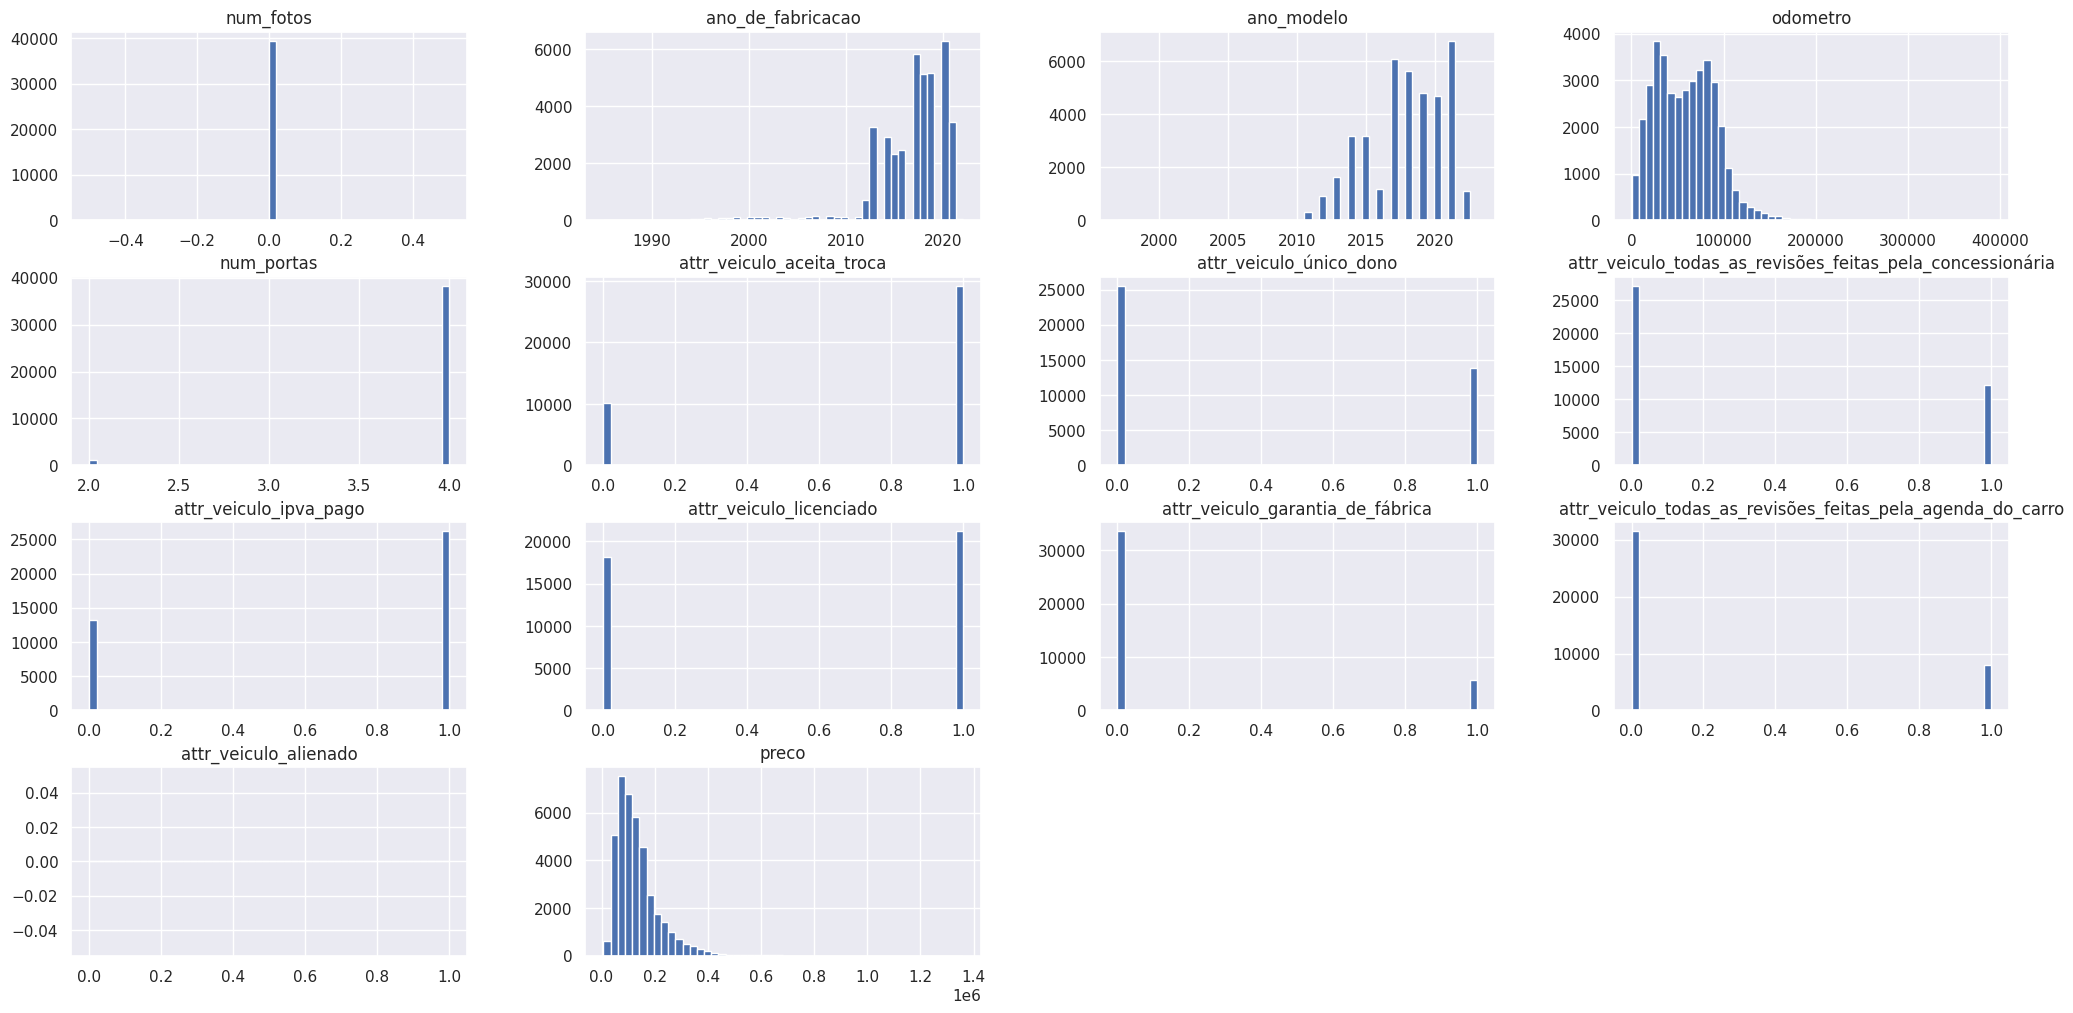

In [133]:
# check numerical features distribution
num_attributes.hist(bins = 50);

### Categorical Attributes

In [99]:
# check unique values of categorical features
cate_attributes.apply( lambda x: x.unique().shape[0])

ID                 39446
marca                 41
modelo               473
versao              2058
cambio                 7
tipo                   8
blindado               2
cor                    8
tipo_vendedor          2
cidade_vendedor      648
estado_vendedor       25
tipo_anuncio           4
dtype: int64

In [104]:
cate_attributes.marca.value_counts()

VOLKSWAGEN       6140
CHEVROLET        4020
TOYOTA           2882
HYUNDAI          2740
JEEP             2667
FIAT             2523
BMW              2375
AUDI             2291
PEUGEOT          2246
HONDA            2097
MERCEDES-BENZ    1501
FORD             1445
MITSUBISHI       1148
LAND ROVER       1027
RENAULT           711
NISSAN            583
KIA               565
PORSCHE           470
VOLVO             363
CITROËN           248
TROLLER           223
RAM               221
JAGUAR            212
CHERY             202
MINI              182
LEXUS              91
SUBARU             54
SUZUKI             51
DODGE              47
CHRYSLER           40
SSANGYONG          20
SMART              16
MASERATI           12
LIFAN              10
ALFA ROMEO         10
JAC                 5
FERRARI             2
EFFA                2
IVECO               2
BRM                 1
LAMBORGHINI         1
Name: marca, dtype: int64

In [105]:
cate_attributes.modelo.value_counts()

COMPASS                 1967
2008                    1924
Q3                      1213
TORO                    1179
COROLLA                 1168
ONIX                    1140
320i                    1082
AMAROK                   958
GOLF                     924
HILUX                    856
CIVIC                    830
CRUZE                    817
POLO                     789
JETTA                    695
HB20S                    621
RENEGADE                 582
STRADA                   553
HB20                     513
MONTANA                  481
VIRTUS                   479
T-CROSS                  469
HILUX SW4                465
IX35                     459
FIT                      441
A3                       414
RANGER                   412
CRETA                    408
ECOSPORT                 400
TIGUAN                   393
HR-V                     388
SPORTAGE                 362
GOL                      361
DISCOVERY SPORT          358
S10                      333
ASX           

In [106]:
cate_attributes.versao.value_counts()

1.6 16V FLEX ALLURE PACK 4P AUTOMÁTICO                                         1825
2.0 16V FLEX LIMITED AUTOMÁTICO                                                1355
2.0 TFSI AMBIENTE QUATTRO 4P GASOLINA S TRONIC                                 1007
1.0 200 TSI COMFORTLINE AUTOMÁTICO                                              624
2.0 HIGHLINE 4X4 CD 16V TURBO INTERCOOLER DIESEL 4P AUTOMÁTICO                  567
1.8 16V EVO FLEX FREEDOM AT6                                                    529
1.4 MPFI LS CS 8V FLEX 2P MANUAL                                                477
2.0 SPORT 16V TURBO ACTIVE FLEX 4P AUTOMÁTICO                                   445
2.0 XEI 16V FLEX 4P AUTOMÁTICO                                                  432
2.0 TSI GTI 16V TURBO GASOLINA 4P AUTOMÁTICO                                    415
1.4 MPI WORKING CS 8V FLEX 2P MANUAL                                            413
1.0 200 TSI TOTAL FLEX COMFORTLINE AUTOMÁTICO                               

In [107]:
cate_attributes.cambio.value_counts()

Automática               30073
Manual                    6631
CVT                       2391
Automatizada               192
Automatizada DCT            71
Semi-automática             56
Automática Sequencial       32
Name: cambio, dtype: int64

In [109]:
cate_attributes.tipo.value_counts()

Sedã                    21910
Hatchback                6570
Picape                   6426
Utilitário esportivo     4458
Perua/SW                   37
Cupê                       34
Minivan                    10
Conversível                 1
Name: tipo, dtype: int64

In [108]:
cate_attributes.blindado.value_counts()

N    39128
S      318
Name: blindado, dtype: int64

In [110]:
cate_attributes.cor.value_counts()

Branco      27919
Preto        6985
Prata        2359
Cinza        2174
Dourado         6
Vermelho        1
Azul            1
Verde           1
Name: cor, dtype: int64

In [111]:
cate_attributes.tipo_vendedor.value_counts()

PF    23857
PJ    15589
Name: tipo_vendedor, dtype: int64

In [112]:
cate_attributes.cidade_vendedor.value_counts()

São Paulo                       8198
Rio de Janeiro                  7739
Belo Horizonte                  2925
Presidente Prudente             2022
Goiânia                         1871
Medianeira                      1578
Campinas                        1088
São José do Rio Preto           1031
Porto Alegre                     892
Ribeirão Preto                   829
Salvador                         753
Recife                           661
São Bernardo do Campo            535
Santos                           535
Curitiba                         489
Jundiaí                          472
Fortaleza                        440
Mogi das Cruzes                  394
São José                         305
São Caetano do Sul               296
Barueri                          281
Praia Grande                     253
Maceió                           232
Sorocaba                         223
Florianópolis                    201
São José dos Campos              187
Joinville                        177
N

In [114]:
cate_attributes.estado_vendedor.value_counts()

São Paulo (SP)              21794
Rio de Janeiro (RJ)          3384
Paraná (PR)                  3380
Santa Catarina (SC)          3119
Minas Gerais (MG)            2350
Rio Grande do Sul (RS)       2191
Goiás (GO)                   1043
Bahia (BA)                    827
Pernambuco (PE)               411
Alagoas (AL)                  171
Paraíba (PB)                  147
Rio Grande do Norte (RN)      119
Pará (PA)                     107
Ceará (CE)                     87
Amazonas (AM)                  66
Mato Grosso (MT)               48
Mato Grosso do Sul (MS)        46
Acre (AC)                      40
Tocantins (TO)                 34
Espírito Santo (ES)            29
Sergipe (SE)                   29
Piauí (PI)                      9
Maranhão (MA)                   7
Rondônia (RO)                   5
Roraima (RR)                    3
Name: estado_vendedor, dtype: int64

In [113]:
cate_attributes.tipo_anuncio.value_counts()

Pessoa Física                       23949
Loja                                13182
Concessionária                       2310
Acessórios e serviços para autos        5
Name: tipo_anuncio, dtype: int64

# FEATURE ENGINEERING

In [194]:
df2 = df1.copy()

In [120]:
df2.head()

,ID,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,odometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,tipo_anuncio,entrega_delivery,troca,elegivel_revisao,attr_veiculo_aceita_troca,attr_veiculo_único_dono,attr_veiculo_todas_as_revisões_feitas_pela_concessionária,attr_veiculo_ipva_pago,attr_veiculo_licenciado,attr_veiculo_garantia_de_fábrica,attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro,attr_veiculo_alienado,preco
0,105869496634249611881157692933406072990,8.0,VOLKSWAGEN,AMAROK,2.0 TRENDLINE 4X4 CD 16V TURBO INTERCOOLER DIE...,2017,2017.0,55672.0,Automática,4,Picape,N,Preto,PF,São Paulo,São Paulo (SP),Pessoa Física,False,False,False,1,0,1,1,1,0,1,NaN,123231.992782
1,14165644411757892901957277406025007093,8.0,JAGUAR,F-PACE,2.0 16V TURBO DIESEL PRESTIGE AWD 4P AUTOMÁTICO,2017,2017.0,47858.0,Automática,4,Utilitário esportivo,N,Branco,PF,Rio de Janeiro,Rio Grande do Sul (RS),Pessoa Física,False,False,False,1,0,1,1,0,0,1,NaN,272076.023576
2,78515656948521351316652580664682810356,14.0,CHEVROLET,CRUZE,1.8 LT 16V FLEX 4P AUTOMÁTICO,2012,2013.0,122323.0,Automática,4,Sedã,N,Prata,PJ,Rio de Janeiro,São Paulo (SP),Loja,True,True,False,1,0,0,0,0,0,0,NaN,53411.539492
3,36797041166808090517929207429817328298,8.0,PORSCHE,718,2.0 16V H4 GASOLINA BOXSTER PDK,2020,2021.0,14207.0,Automática,2,Picape,N,Branco,PF,São Paulo,São Paulo (SP),Pessoa Física,False,False,False,1,0,1,0,0,0,0,NaN,299697.071937
4,338618517701891995317200439137014723900,8.0,VOLVO,XC90,2.0 INSCRIPTION TURBO GASOLINA 4P 4X4 AUTOMÁTICO,2015,2016.0,43760.0,Automática,4,Utilitário esportivo,N,Preto,PF,Ribeirão Preto,São Paulo (SP),Pessoa Física,False,False,False,1,0,1,0,0,0,1,NaN,255164.344178


In [119]:
df2.columns

Index(['ID', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado', 'preco'],
      dtype='object')

## Hypothesis Mindmap

## Creating Hypothesis

## Final Hypothesis List

## Feature Engineering

# VARIABLE FILTERING

In [195]:
df3 = df2.copy()

## Line Filtering

## Columns Selection

In [137]:
df3.columns

Index(['ID', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado', 'preco'],
      dtype='object')

In [196]:
# primeiro momento deletar algumas features para agilizar o primeiro ciclo

# marca
# modelo
# versao
# cidade_vendedor

df3 = df3.drop(['marca', 'modelo', 'versao', 'cidade_vendedor','attr_veiculo_alienado' ], axis = 1)


In [197]:
df3.isna().sum()

ID                                                            0
num_fotos                                                     0
ano_de_fabricacao                                             0
ano_modelo                                                    0
odometro                                                      0
cambio                                                        0
num_portas                                                    0
tipo                                                          0
blindado                                                      0
cor                                                           0
tipo_vendedor                                                 0
estado_vendedor                                               0
tipo_anuncio                                                  0
entrega_delivery                                              0
troca                                                         0
elegivel_revisao                        

# EXPLORATORY DATA ANALYSIS (EDA)

In [198]:
df4 = df3.copy()

## Univariate Analysis

### Response Variable

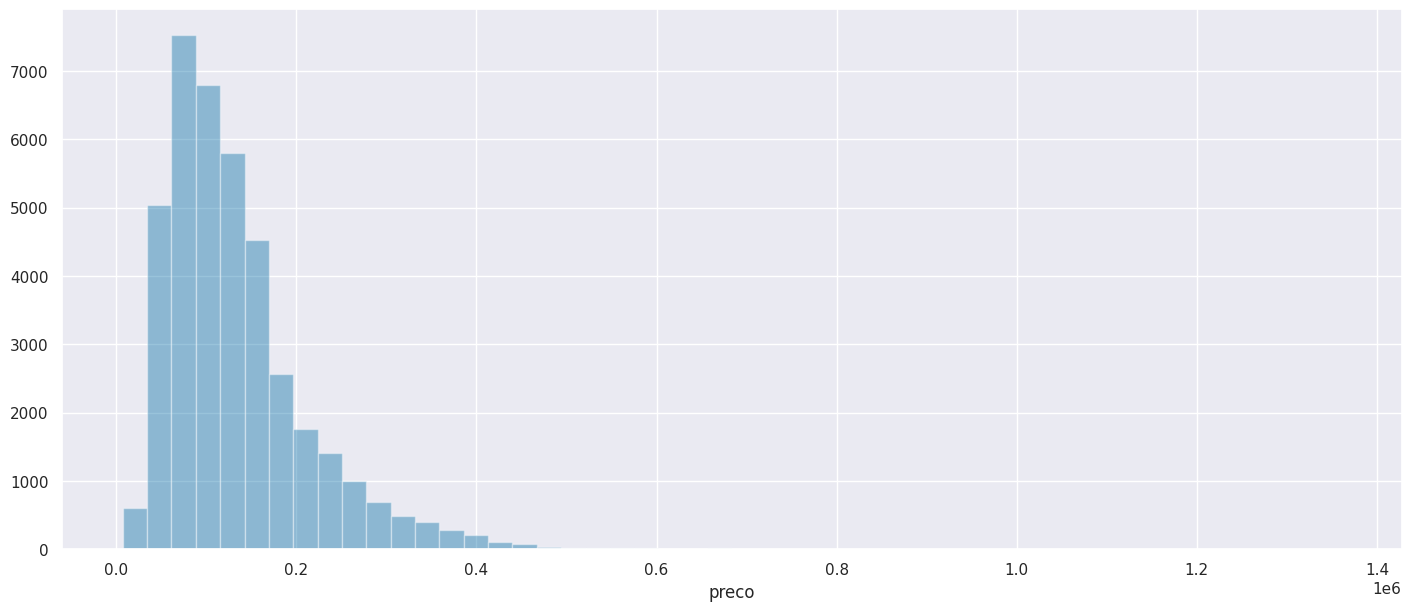

In [199]:
# plot target variable distribution
fig = plt.figure( figsize = (14, 6), constrained_layout=True)
sns.distplot(df4['preco'], kde = False);
plt.style.use('tableau-colorblind10');

- It is not close to a normal distribution. 
- Skew far to the right.
- The more normal the response variable, the better the algorithm will perform. We might have to use log transformation later on it

### Numerical Variable

In [200]:
num_attributes = df4.select_dtypes( include = 'number')

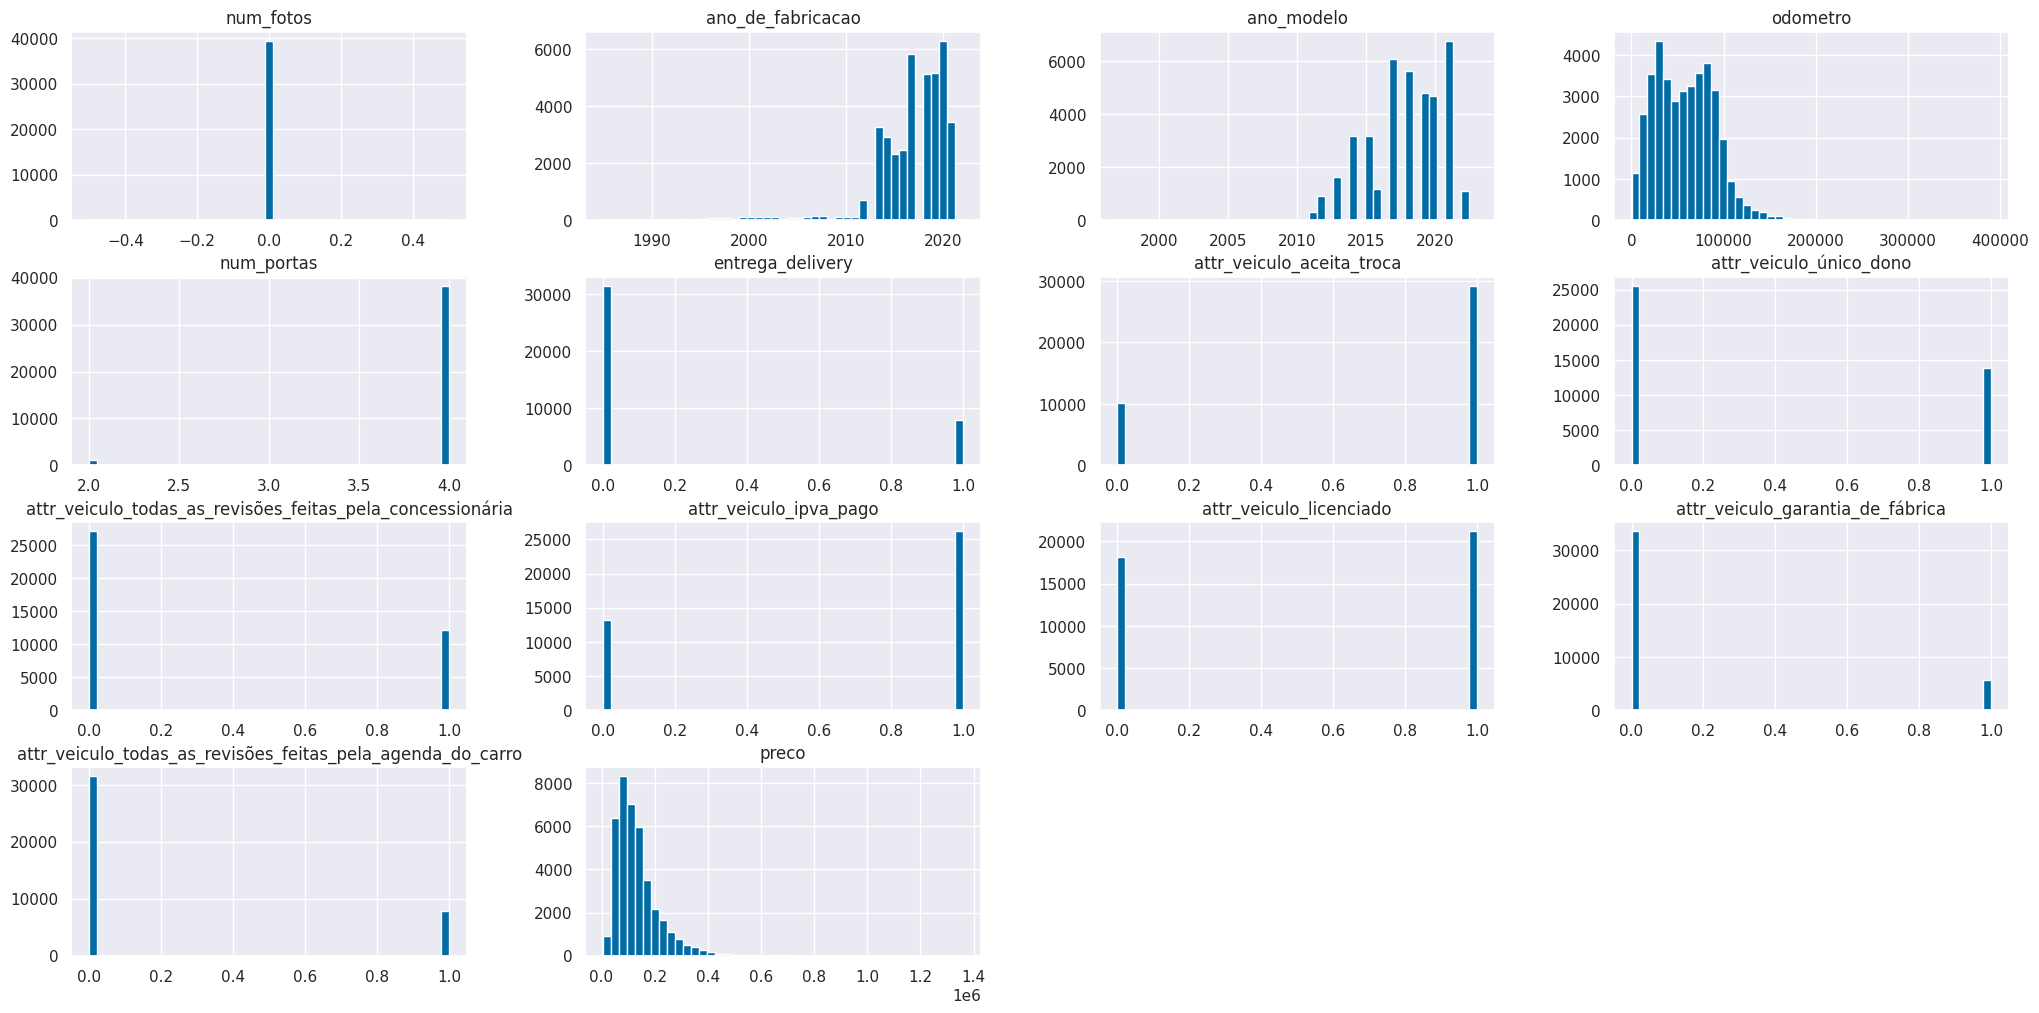

In [176]:
# histogram for numerical features
num_attributes.hist(bins = 45);
plt.style.use('tableau-colorblind10');

In [144]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m1 = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,num_fotos,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
1,ano_de_fabricacao,1985.000000,2.022000e+03,3.700000e+01,2016.748137,2018.000000,4.084710,-2.512826,9.277637
2,ano_modelo,1997.000000,2.023000e+03,2.600000e+01,2017.807154,2018.000000,2.675300,-0.498274,-0.534887
3,odometro,100.000000,3.900650e+05,3.899650e+05,58382.243371,57244.500000,32542.380554,0.606748,1.251382
4,num_portas,2.000000,4.000000e+00,2.000000e+00,3.941135,4.000000,0.337206,-5.568483,29.052409
5,attr_veiculo_aceita_troca,0.000000,1.000000e+00,1.000000e+00,0.741013,1.000000,0.438078,-1.100361,-0.789246
6,attr_veiculo_único_dono,0.000000,1.000000e+00,1.000000e+00,0.352330,0.000000,0.477696,0.618284,-1.617807
7,attr_veiculo_todas_as_revisões_feitas_pela_con...,0.000000,1.000000e+00,1.000000e+00,0.310272,0.000000,0.462605,0.820289,-1.327193
8,attr_veiculo_ipva_pago,0.000000,1.000000e+00,1.000000e+00,0.664782,1.000000,0.472067,-0.698158,-1.512652
9,attr_veiculo_licenciado,0.000000,1.000000e+00,1.000000e+00,0.538711,1.000000,0.498499,-0.155317,-1.975977


### Categorical Variable

In [201]:
cate_attributes = df4.select_dtypes( include = 'object')

In [178]:
cate_attributes.columns

Index(['ID', 'cambio', 'tipo', 'blindado', 'cor', 'tipo_vendedor',
       'estado_vendedor', 'tipo_anuncio'],
      dtype='object')

## Bivariate Analysis

## Multivariate Analysis

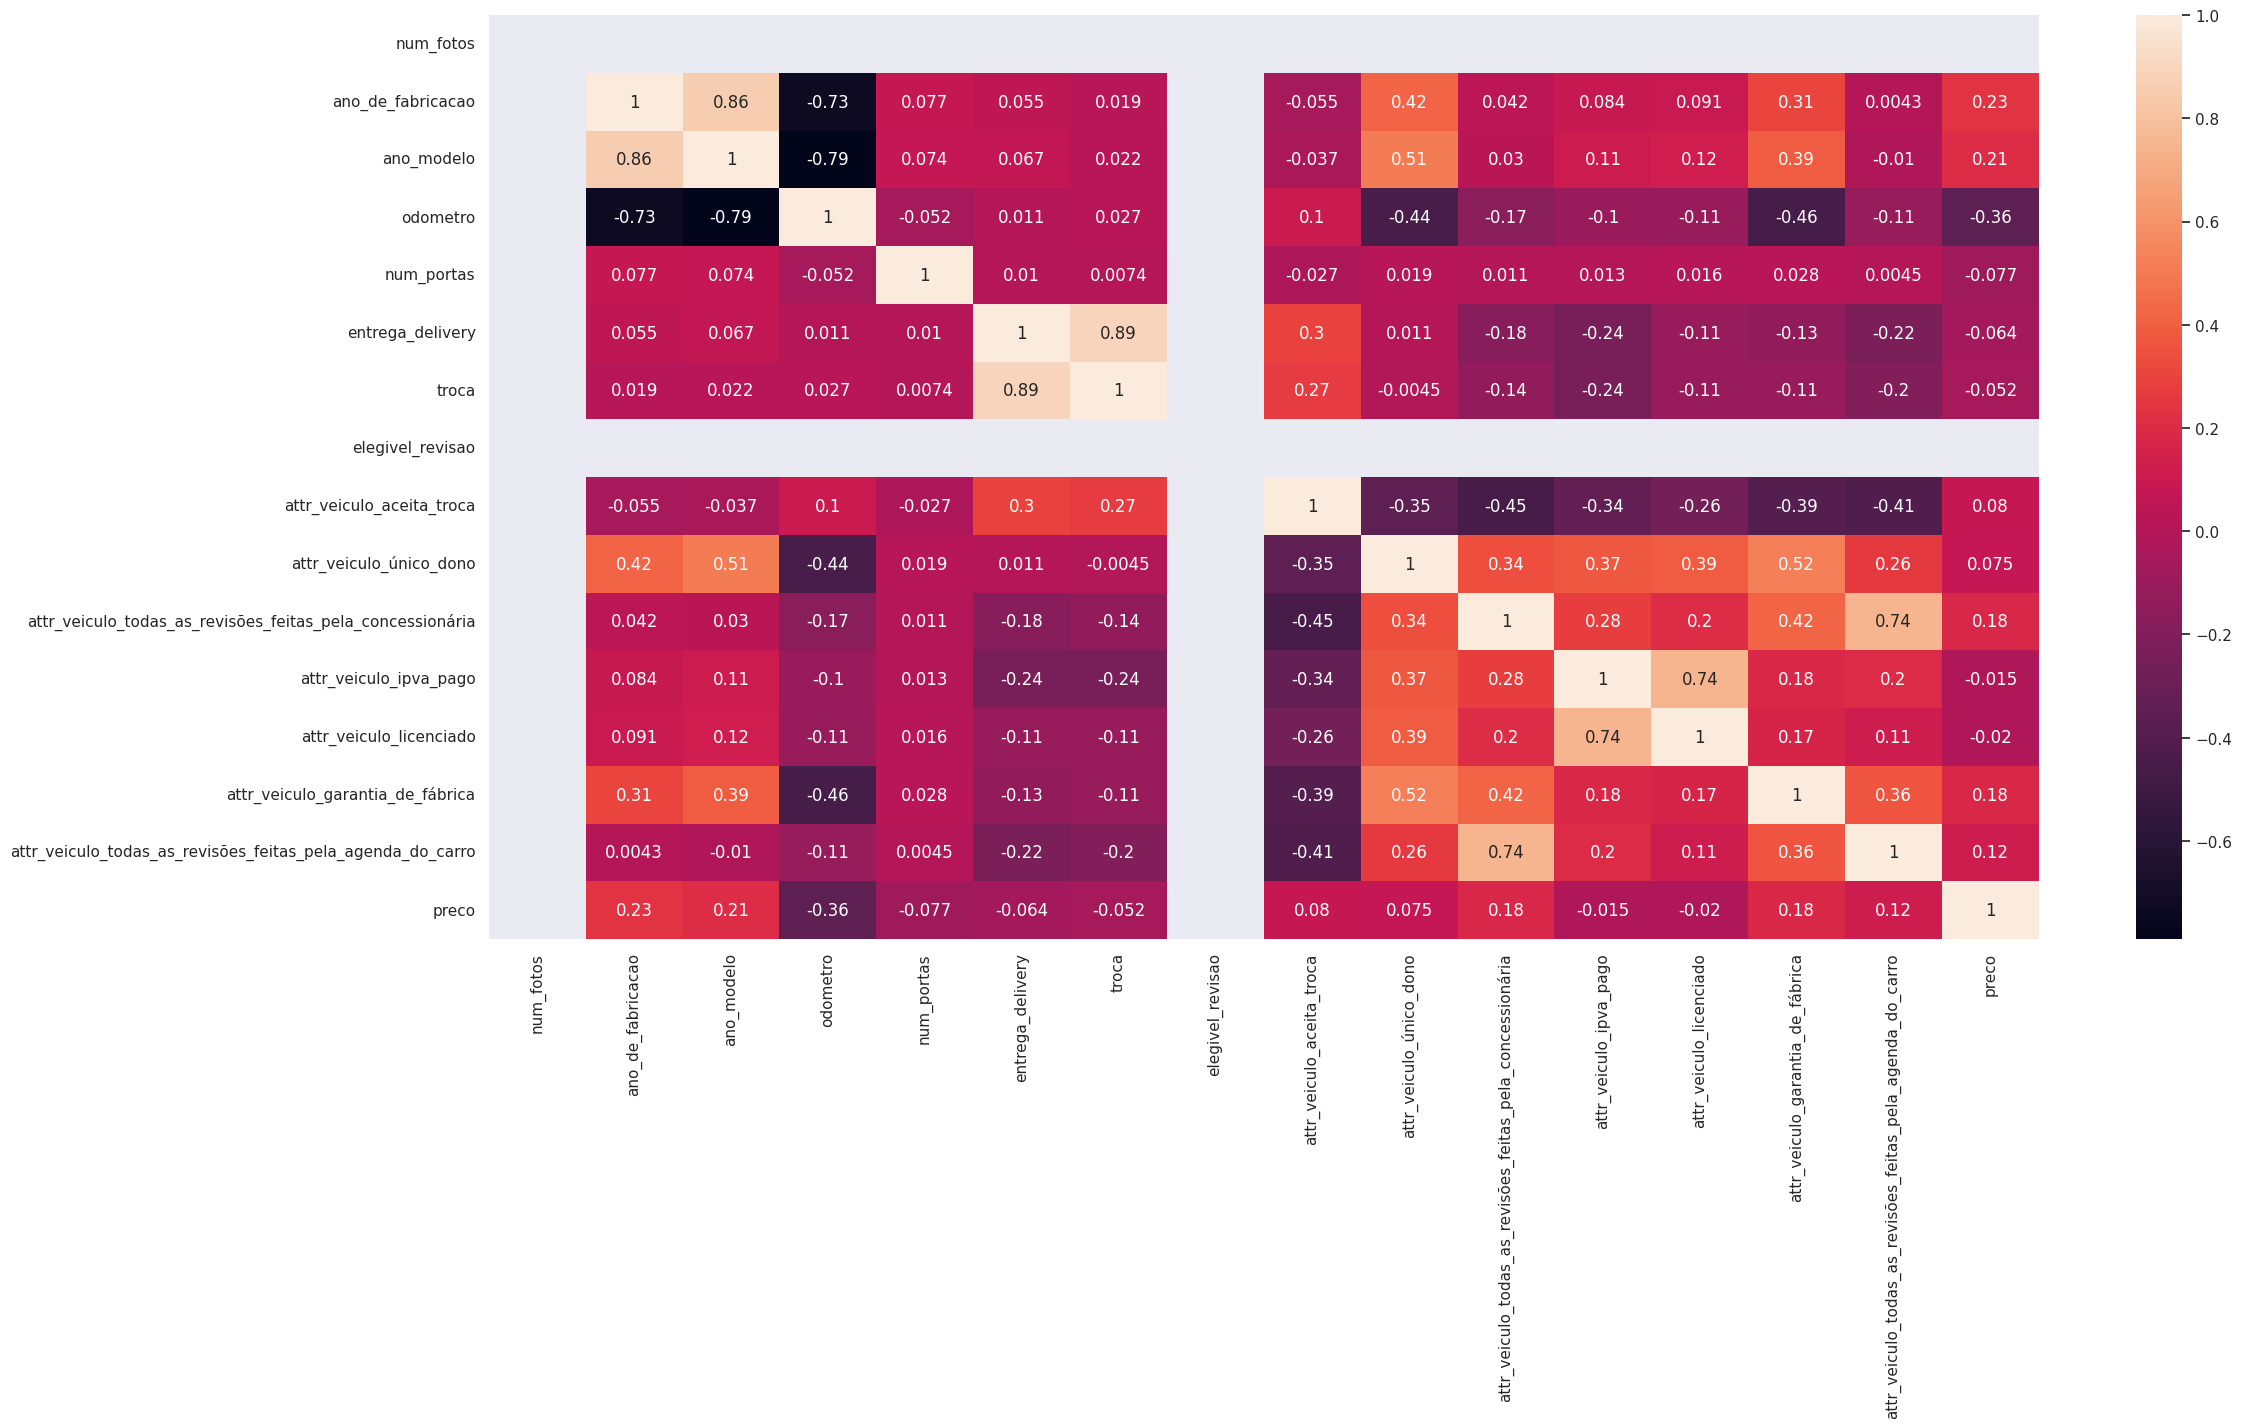

In [202]:
# correlation among all variables
correlation = (num_attributes.corr( method = 'pearson' ))
sns.heatmap( correlation, annot = True );

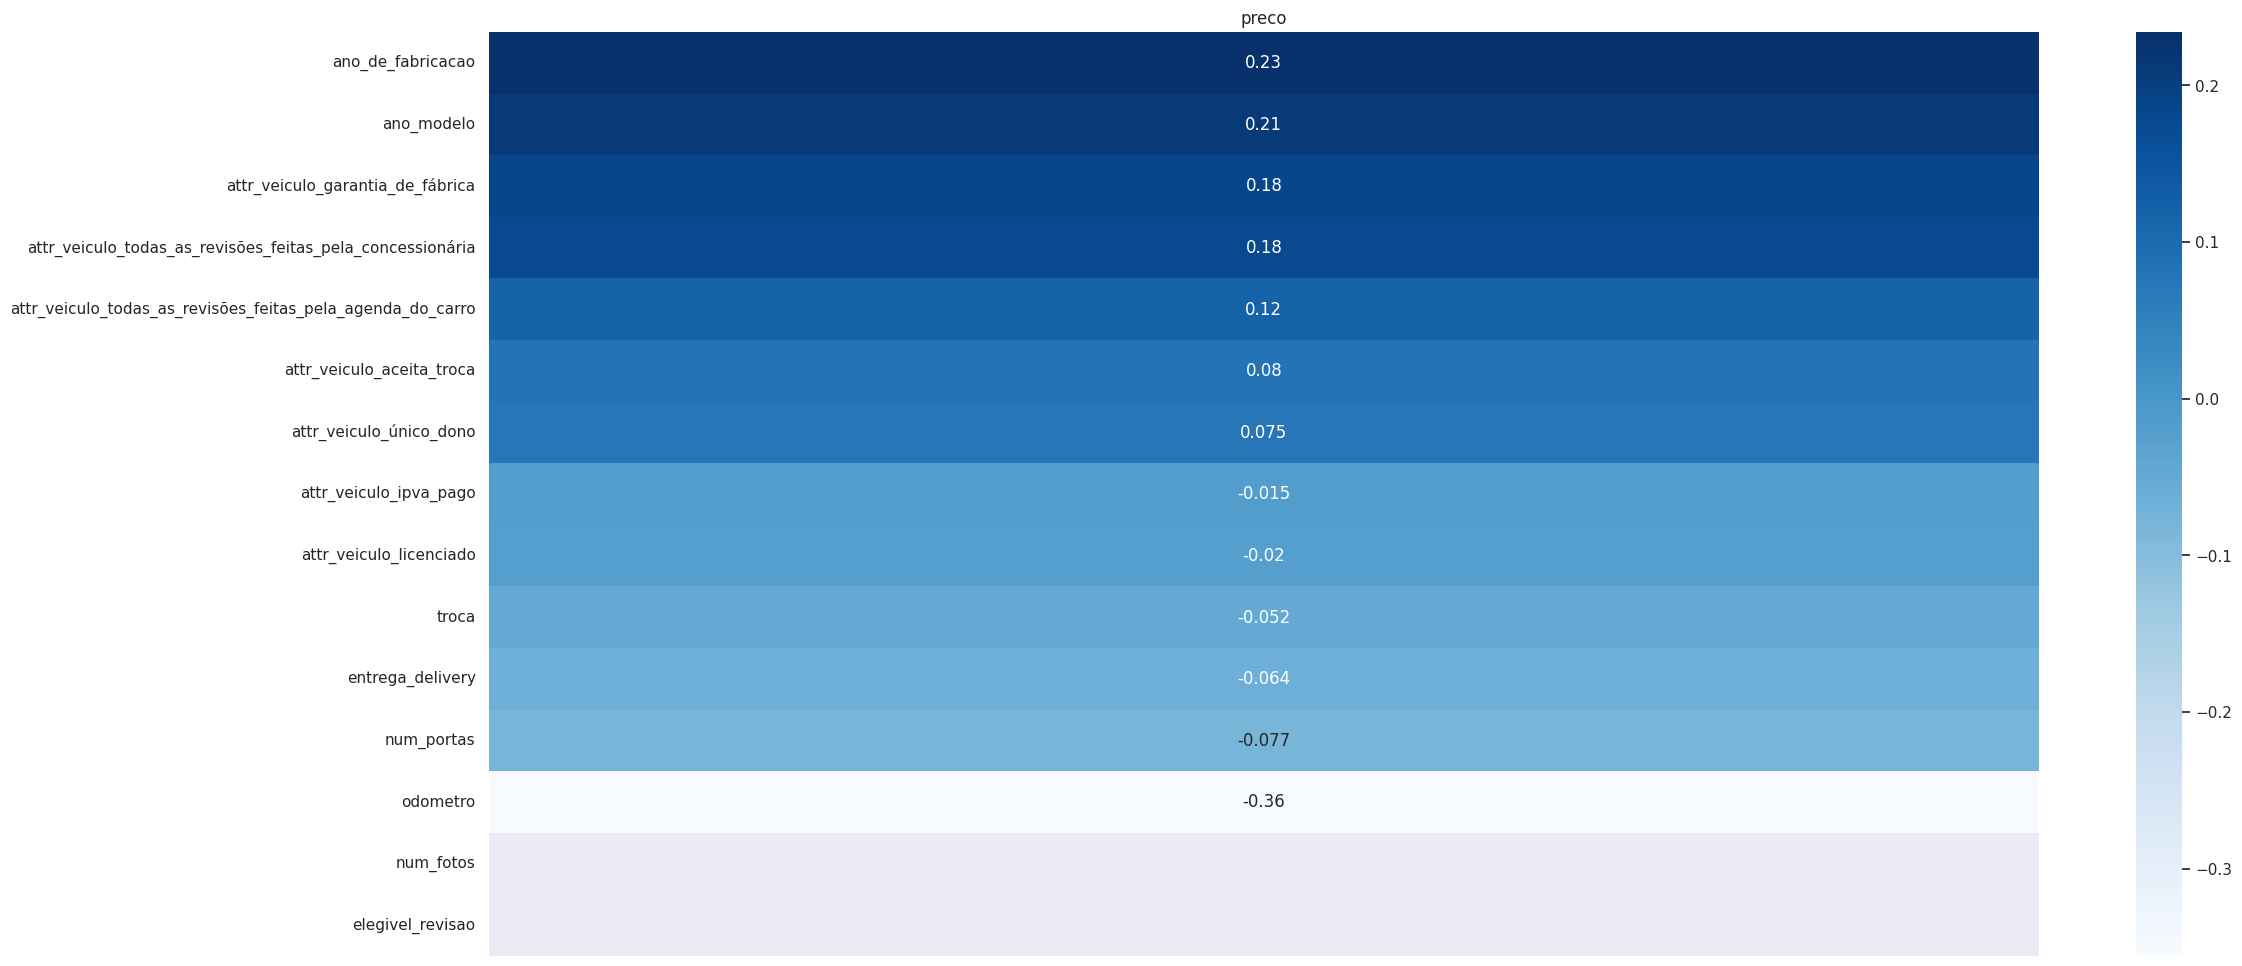

In [203]:
def plot_corr(col):
    a = correlation[col].sort_values(ascending=False).to_frame()
    a.columns = ['']
    a.drop(col, axis=0, inplace=True)
    plot = sns.heatmap( a, annot=True, cmap='Blues').set_title(col);
    
    return plot

plot_corr('preco');

# DATA PREPARATION

In [204]:
df5 = df4.copy()

The rescaling methods applied below are based on the features distribution shape and boxplot outlier analysis.

- Standard Scaler: applied on variables with a distribution shape similar to a normal distribution;
- Min-Max Scaler: applied on variables with low outliers influence;
- Robust Scaler: applied on variables with high outliers influence.

### split dataframe training and validation

In [205]:
# drop target variable from training set
X = df4.drop('preco', axis = 1).copy()
y = df4['preco'].copy()

#apply stratief split to split train and test datasets, 80% for training and 20% for test
X_train, X_validation, y_train, y_ = train_test_split(X, y, test_size = 0.15, random_state = 42, 
                                                            shuffle = True)

#stratify = yes preservers class proportion 

In [206]:
# check the proportion of validation data datapoints
X_validation.shape[0]/df5.shape[0] * 100

15.000253511129138

In [207]:
# check the proportion of validation data datapoints
X_train.shape[0]/df5.shape[0] * 100

84.99974648887087

### Checking features outliers presence

In [208]:
num_attributes = X_train.select_dtypes( exclude = 'object')

In [186]:
num_attributes.columns

Index(['num_fotos', 'ano_de_fabricacao', 'ano_modelo', 'odometro',
       'num_portas', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_único_dono',
       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fábrica',
       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'],
      dtype='object')

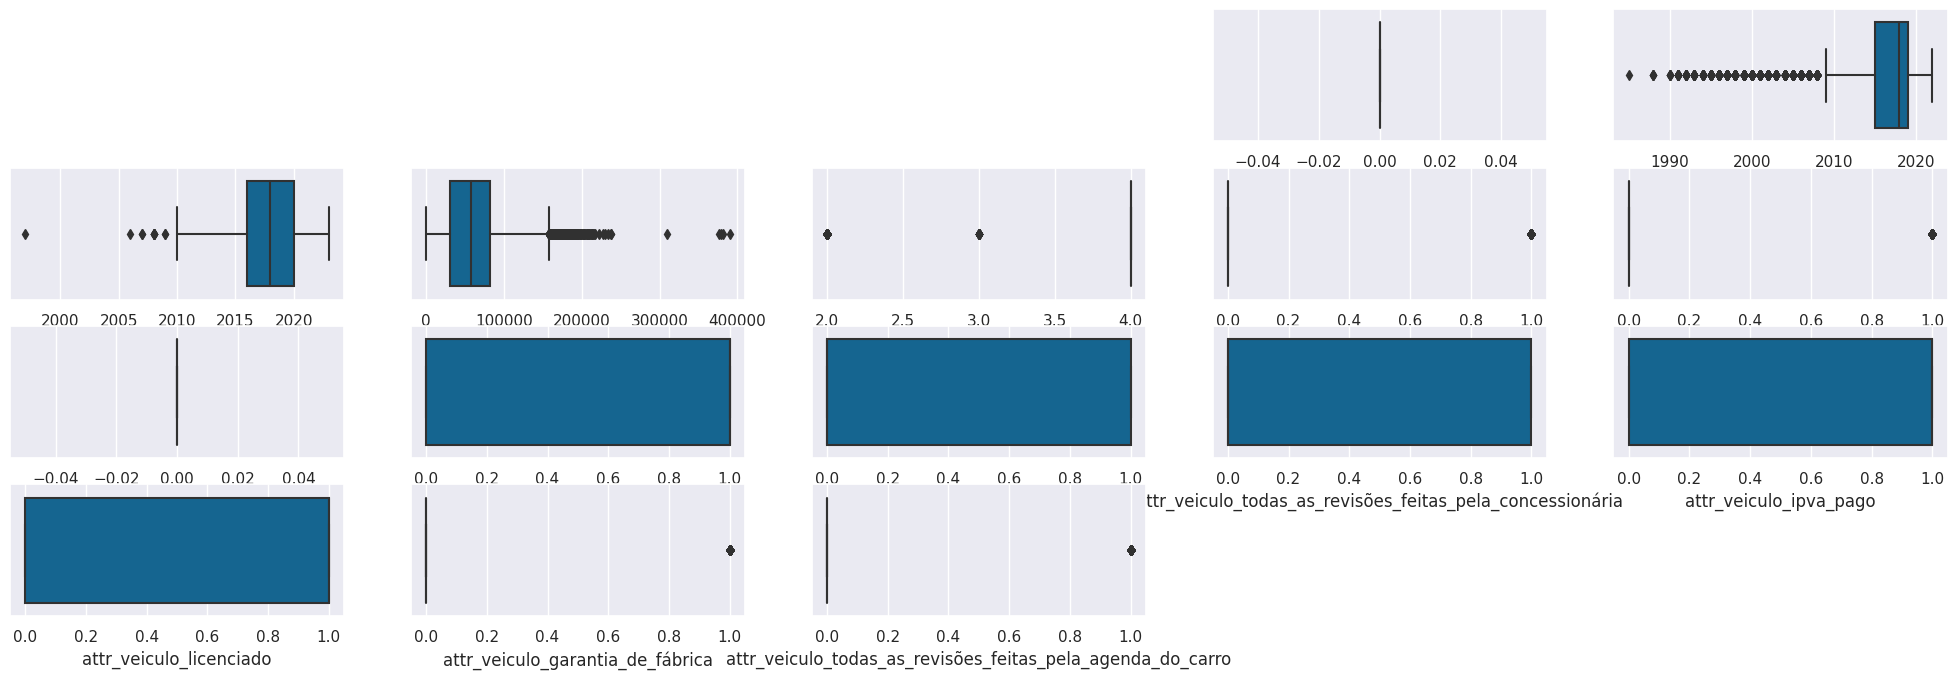

In [209]:
# plot boxplots features in order to check outliers presence
plt.subplot(6, 5, 9)
sns.boxplot(df5['num_fotos'])

plt.subplot(6, 5, 10)
sns.boxplot(df5['ano_de_fabricacao'])

plt.subplot(6, 5, 11)
sns.boxplot(df5['ano_modelo'])

plt.subplot(6, 5, 12)
sns.boxplot(df5['odometro'])

plt.subplot(6, 5, 13)
sns.boxplot(df5['num_portas'])

plt.subplot(6, 5, 14)
sns.boxplot(df5['entrega_delivery'])

plt.subplot(6, 5, 15)
sns.boxplot(df5['troca'])

plt.subplot(6, 5, 16)
sns.boxplot(df5['elegivel_revisao'])

plt.subplot(6, 5, 17)
sns.boxplot(df5['attr_veiculo_aceita_troca'])

plt.subplot(6, 5, 18)
sns.boxplot(df5['attr_veiculo_único_dono'])

plt.subplot(6, 5, 19)
sns.boxplot(df5['attr_veiculo_todas_as_revisões_feitas_pela_concessionária'])

plt.subplot(6, 5, 20)
sns.boxplot(df5['attr_veiculo_ipva_pago'])

plt.subplot(6, 5, 21)
sns.boxplot(df5['attr_veiculo_licenciado'])

plt.subplot(6, 5, 22)
sns.boxplot(df5['attr_veiculo_garantia_de_fábrica'])

plt.subplot(6, 5, 23)
sns.boxplot(df5['attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'])

fig.tight_layout()

In [210]:
num_attributes.attr_veiculo_licenciado.value_counts()

1    18017
0    15512
Name: attr_veiculo_licenciado, dtype: int64

## Feature Normalization

## Feature Rescaling

## Feature Transformation

### Enconding

### Target Variable Transformation

### Nature Transformation

# FEATURE SELECTION

## Spliting dataframe into training and test dataset

## Feature Selector (boruta?)

## Best Features

# MACHINE LEARNING ALGORITHM MODELS

## Modelo 1

## Modelo 2

## Modelo 3

## Compare Model's Performance

# HYPERPARAMETERS FINE TUNING

# ERROR INTERPRETATION

# MODEL DEPLOYMENT